In [37]:
import pandas as pd
import numpy as np
import json
from pathlib import Path

import spacy
import nltk
nltk.download('stopwords')

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


import scipy.stats as st
from sklearn.metrics import mean_absolute_error, mean_squared_error

import matplotlib.pyplot as plt

from master_thesis.src import utils

pd.set_option('display.max_columns', 80) # make all columns visible
import xgboost

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ruecker/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
import pickle
import shap

shap.initjs()

## BOW

In [214]:
# loading model with pickle
feature_type = "abs"
max_features = 1000 #500 # 200
modeltype = "xgboost" # "ridge"
publisher = "NOZ"

model_PATH = utils.OUTPUT / 'saved_models' / f'BOW_{modeltype}_{feature_type}_{str(max_features)}.pkl'

with open(model_PATH, 'rb') as p_in:
    model = pickle.load(p_in)
    

In [215]:
model

XGBRegressor(max_depth=10, missing=nan, n_estimators=300, random_state=1)

In [216]:
# loading features

print("loading features...", feature_type)
X_train = np.load(utils.OUTPUT / 'BOW_features' / f'{publisher}_X_train_{feature_type}_{str(max_features)}.npy')
X_dev = np.load(utils.OUTPUT / 'BOW_features' / f'{publisher}_X_dev_{feature_type}_{str(max_features)}.npy')
X_test = np.load(utils.OUTPUT / 'BOW_features' / f'{publisher}_X_test_{feature_type}_{str(max_features)}.npy')



loading features... abs


In [253]:
print(modeltype)

# ridge
if modeltype == "ridge":
    explainer = shap.LinearExplainer(model, X_train)
    shap_values = explainer.shap_values(X_dev)

# xgboost
if modeltype == "xgboost":
    #explainer = shap.KernelExplainer(model.predict, X_dev[:100])
    #shap_values = explainer.shap_values(X_dev[:100])
    
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_dev)
    
    #explainer = shap.TreeExplainer(model, X_train) # mit oder ohne (, X_train) ??
    #shap_values = explainer.shap_values(X_dev) # explainer.shap_values(X_dev)
    #shap_values = explainer(X_dev) # für manche plots ist das nötig, für andere das drüber...

xgboost


In [279]:
shap_values.shape

(3638, 1000)

In [222]:
# loading vectorizer and feature_names

with open(utils.OUTPUT / 'BOW_features' / f'{publisher}_vectorizer_{str(max_features)}.pkl', 'rb') as fp:
    vectorizer = pickle.load(fp)
    
feature_names = vectorizer.get_feature_names()
print(len(feature_names))

Trying to unpickle estimator CountVectorizer from version 0.22 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.


1000


In [223]:
vectorizer

CountVectorizer(max_features=1000, min_df=5, ngram_range=(1, 5),
                preprocessor=<master_thesis.src.utils.Preprocessor object at 0x7fa38f8c2e50>,
                stop_words=['', '', 'alle', 'alle', '', 'alle', '', '', '', '',
                            '', '', '', '', '', '', '', '', '', '', '', '', '',
                            '', 'sein', '', 'sein', '', '', '', ...])

In [224]:
feature_names[657]#[100:120] # find the name of a feature

'osnabrück'

In [225]:
feature_names.index("statt") # search for a specific token

800

In [226]:
feature_names.index("foto") # search for a specific token

346

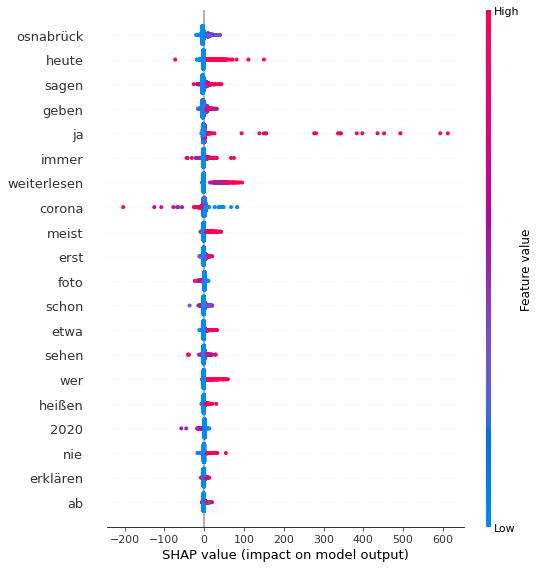

In [258]:
#shap.summary_plot(shap_values, X_dev, feature_names = feature_names)
#shap.summary_plot(shap_values, X_dev[:100], feature_names = feature_names)
shap.summary_plot(shap_values, features=X_dev, feature_names=feature_names)

In [229]:
type(shap_values)

numpy.ndarray

In [278]:
shap_values.shape

(3638, 1000)

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


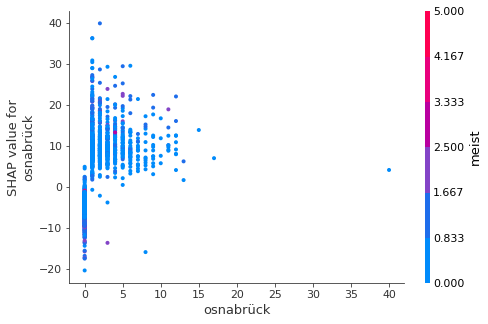

In [261]:
shap.dependence_plot("osnabrück", shap_values, X_dev, feature_names = feature_names)

In [262]:
i = 25
shap.force_plot(explainer.expected_value, shap_values[i], features=X_dev[i], feature_names=feature_names)


In [252]:
#shap_values[i]

In [231]:
# ein bestimmtes Feature (token) anschauen:

token = "osnabrück"
token_id = feature_names.index(token) # search for a specific token
print(f"Dast Token \"{token}\" ist an der Stelle: \n{token_id}")

Dast Token "osnabrück" ist an der Stelle: 
657


In [232]:
shap_values[:, token_id][:20] # "foto" 
# die ersten 20 Dokumente und der shap_value für "foto"

array([-4.78431434, -4.1353308 , -3.83361684, -3.95959341, -4.28246373,
       -8.51819684,  9.03006858, -5.45362531,  5.88346615, -5.01387141,
       -3.51426949, -5.41338241, -6.14949888, -3.3808964 , -4.63392766,
       -2.46438259,  8.22746015, 16.43660439, -2.41976672, -4.11658684])

In [233]:
X_dev[:, token_id][:20]
# die absoluten counts von "foto" in den ersten 20 Dokumenten

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 3, 4, 0, 0])

In [234]:
print(np.mean(shap_values[:, token_id].values)) # mean shap_value for one token/feature
print(np.mean(abs(shap_values[:, token_id].values))) # mean (abs!) shap_value for one token/feature

AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [235]:
plt.hist(shap_values[:, token_id].values, 40)
plt.xlim(-10,10)
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [263]:
plt.scatter(shap_values[:, token_id].data, shap_values[:, 346].values, alpha = 0.2)

AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [264]:
shap.plots.bar(shap_values)#, feature_names = feature_names)
# das zeigt den mean ABS value über die Dokumente! Also zum Bsp. "corona" hat sowohl negative als auch positive shap_values, 
# hier ist aber die abs gemittelt und daher der Wert größer als er ohne abs wäre

AssertionError: The shap_values paramemter must be a shap.Explanation object!

In [265]:
shap.plots.beeswarm(shap_values)#, feature_names = feature_names)

UnboundLocalError: local variable 'features' referenced before assignment

In [266]:
shap.plots.waterfall(shap_values[0]) # one prediction

AttributeError: 'numpy.ndarray' object has no attribute 'base_values'

In [267]:
feature_names[56]

'allerdings'

In [268]:
shap_values[0].data[56]

9.589376449584961

In [269]:
shap_values[0].values[657]

AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [270]:
dev_preds.article_text[0][:500]

'Initiative "Grün statt Grau" übt Kritik: Das grüne Gewerbegebiet in Melle ist "nicht grün genug" Melle. Nachhaltig, ökologisch, zukunftsfähig: So soll das 18 Hektar große Gewerbegebiet in Melle zwischen Gesmolder Straße, Am Fuhlenkamp, Kirchbreedeweg und der A30 nach dem Willen der Stadt und der Bürgerinitiative "Grün statt Grau" konzipiert werden. Die bisherigen Bemühungen der Kommune gehen der Initiative allerdings nicht weit genug. Sie verlangt Nachbesserungen. "Der erste Entwurf des Bebauung'

In [271]:
shap.force_plot(explainer.expected_value[0], shap_values[0])

IndexError: invalid index to scalar variable.

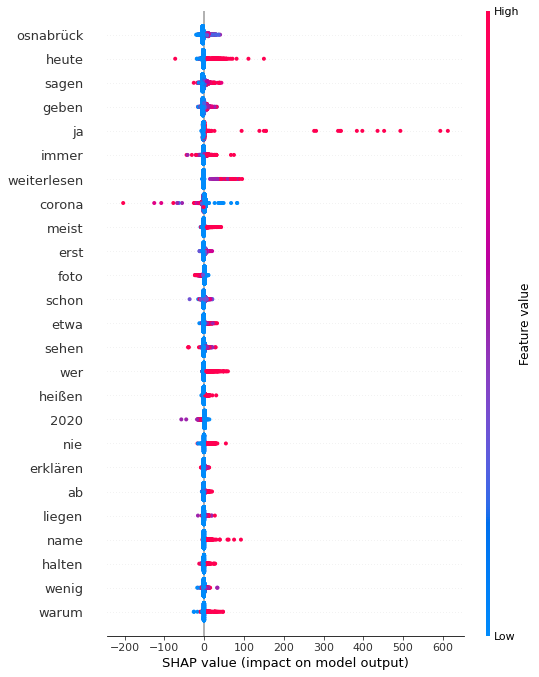

In [272]:
shap.summary_plot(shap_values, X_dev, feature_names=feature_names, max_display = 25)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

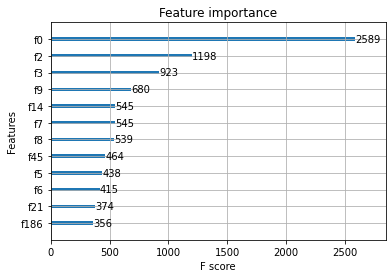

In [273]:
xgboost.plot_importance(model, max_num_features = 12,
                       importance_type ="weight") # "weight" "gain" cover"

In [274]:
feature_names[657]

'osnabrück'

In [275]:
feature_names[608]

'mutter'

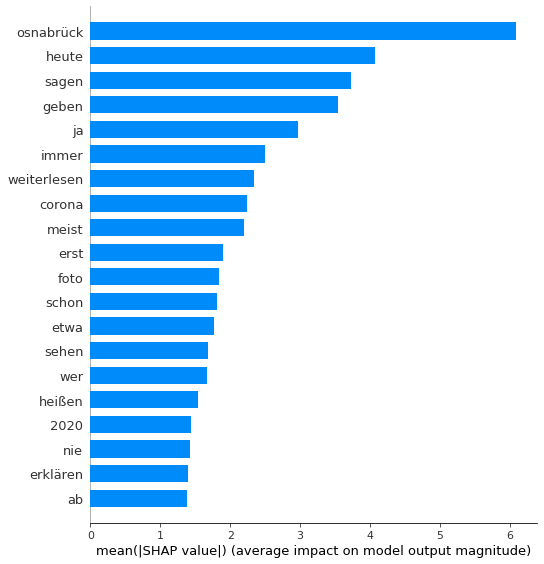

In [276]:
shap.summary_plot(shap_values, X_dev, plot_type="bar", feature_names=feature_names)

In [277]:
ind = 0
shap.force_plot(explainer.expected_value,
                shap_values[ind,:],
                X_dev[ind,:],
                feature_names=feature_names
               )

In [212]:
explainer.expected_value

188.84620811614616

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


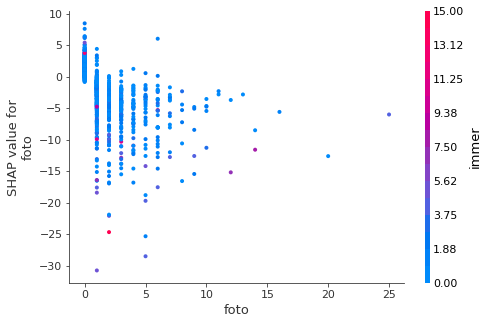

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


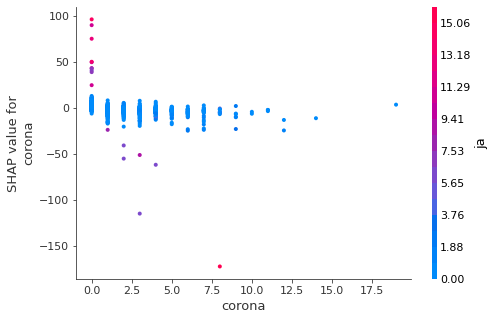

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


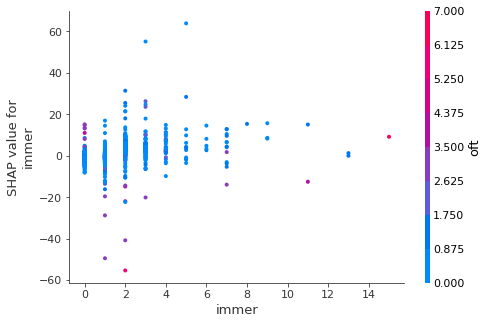

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


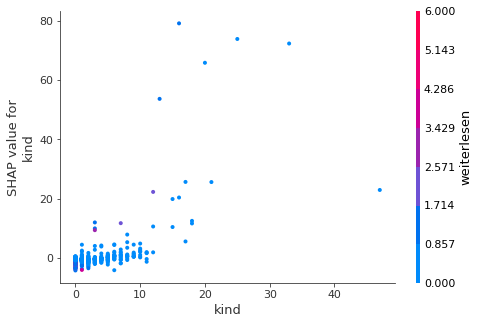

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


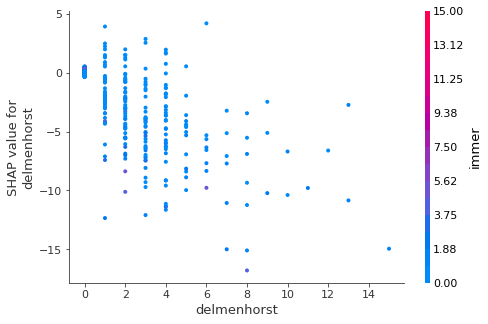

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


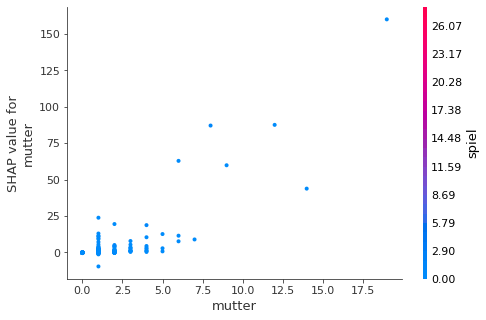

In [213]:
shap.dependence_plot("foto", shap_values, X_dev, feature_names=feature_names)
shap.dependence_plot("corona", shap_values, X_dev, feature_names=feature_names)
shap.dependence_plot("immer", shap_values, X_dev, feature_names=feature_names)
shap.dependence_plot("kind", shap_values, X_dev, feature_names=feature_names)
shap.dependence_plot("delmenhorst", shap_values, X_dev, feature_names=feature_names)
shap.dependence_plot("mutter", shap_values, X_dev, feature_names=feature_names)


# interessant: Corona wirkt sich *negativ* aus

In [ ]:
# so soll man angeblich plots speichern können

#import matplotlib.pyplot as plt
#f = plt.figure()
#shap.summary_plot(rf_shap_values, X_test)
#f.savefig("/summary_plot1.png", bbox_inches='tight', dpi=600)

In [203]:
def model_predict(data):
    if isinstance(data, list):        
        X = vectorizer.transform(data)
        X = X.toarray()
        outputs = model.predict(X)
    if isinstance(data, np.ndarray):
        outputs = model.predict(data)
    return np.array(outputs)

In [204]:
model_predict(["Das hier ist ein Artikel, der ist voll spannend. Geht um nen Unfall und einen Kindergarten und die neuste Mode."])

array([111.24805], dtype=float32)

In [205]:
PUBLISHER= "NOZ"
with open(utils.OUTPUT / "splits" / f"{PUBLISHER}_splits.json", "r") as f:
    splits = json.load(f)
    dev_IDs = splits["dev"]

In [206]:
NOZ = utils.get_publisher_df("NOZ")

Shape of df: (36383, 31)


In [207]:
NOZ_dev = NOZ.loc[dev_IDs]

In [208]:
NOZ_dev.head()

,pageviews,exits,entrances,bounces,timeOnPage,category,rubric,title,date,titel,prozentDpa,prozentVerlag,zeilen,pagePath,dpaGuid,article_text,titel_html,other_content,teaser,article_body,avgTimeOnPage,nr_tokens_text,avgTimeOnPagePerWordcount,avgTimeOnPage_percentile,pageviews_percentile,avgTimeOnPagePerWordcount_percentile,language,nr_tokens_text_punct,nr_tokens_text_BERT,publisher,nr_tokens_publisher
articleId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
NOZ_2093706,448,187,86,20,54204.0,lokales,melle,das-gruene-gewerbegebiet-in-melle-ist-nicht-gr...,NaN,"Initiative ""Grün statt Grau"" übt Kritik: Das g...",NaN,NaN,NaN,NaN,NaN,"Initiative ""Grün statt Grau"" übt Kritik: Das g...","Initiative ""Grün statt Grau"" übt Kritik: Das g...",no,"Melle. Nachhaltig, ökologisch, zukunftsfähig: ...","""Der erste Entwurf des Bebauungsplanes ist ein...",207.678161,705,0.294579,72.050268,53.606490,27.254341,de,785,987,NOZ,705
NOZ_1990893,189,116,107,25,11896.0,NaN,www.noz.de,staatssekretaer-sieht-delmenhorster-krankenhau...,NaN,Heiger Scholz zu Besuch im JHD: Staatssekretär...,NaN,NaN,NaN,NaN,NaN,Heiger Scholz zu Besuch im JHD: Staatssekretär...,Heiger Scholz zu Besuch im JHD: Staatssekretär...,no,Delmenhorst. Staatssekretär Heiger Scholz aus ...,"Er hat nicht lang nachdenken müssen, als die F...",162.958904,576,0.282915,46.143532,22.539996,24.593219,de,645,806,NOZ,576
NOZ_2053403,421,294,257,75,25541.0,lokales,soegel,so-feiern-katholiken-in-boerger-und-surwold-zu...,NaN,Pfarreiengemeinschaft gibt sich neue Regeln: S...,NaN,NaN,NaN,NaN,NaN,Pfarreiengemeinschaft gibt sich neue Regeln: S...,Pfarreiengemeinschaft gibt sich neue Regeln: S...,no,Börger. Mit Beschränkungen bei den Wochenend-G...,„Wir haben uns die Entscheidungen und Maßnahme...,201.110236,457,0.440066,69.039178,51.721434,56.835742,de,516,705,NOZ,457
NOZ_2093781,261,127,89,36,13485.0,deutschland-und-welt,vermischtes,drei-monate-altes-baby-stirbt-in-japan-durch-v...,NaN,Erneuter Fall in Tokio: Drei Monate altes Baby...,NaN,NaN,NaN,NaN,NaN,Erneuter Fall in Tokio: Drei Monate altes Baby...,Erneuter Fall in Tokio: Drei Monate altes Baby...,no,Tokio. Wenige Wochen nach einem schweren Fall ...,In der japanischen Hauptstadt Tokio hat eine 3...,100.634328,261,0.385572,11.410326,34.637760,47.295700,de,292,330,NOZ,261
NOZ_2133782,1121,929,896,742,25763.0,deutschland-und-welt,nordrhein-westfalen,radfahrer-sticht-frau-in-luebbecke-von-hinten-...,NaN,Leichte Schnittverletzung: Radfahrer sticht Fr...,NaN,NaN,NaN,NaN,NaN,Leichte Schnittverletzung: Radfahrer sticht Fr...,Leichte Schnittverletzung: Radfahrer sticht Fr...,no,Lübbecke. Die Polizei ermittelt nach eigenen A...,Als die 25-jährige Lübbeckerin mit ihrem Fahrr...,134.182292,282,0.475824,27.767930,74.932961,62.103445,de,311,405,NOZ,282


In [209]:
dev_preds = model_predict(X_dev)

In [210]:
dev_preds = pd.DataFrame(dev_preds, index = NOZ_dev.index, columns = ["pred"])

In [211]:
dev_preds.head()

,pred
articleId,
NOZ_2093706,202.836761
NOZ_1990893,183.030060
NOZ_2053403,167.942581
NOZ_2093781,195.478363
NOZ_2133782,152.662170


In [212]:
# append text (just for inspecting)
for id_nr, ID in enumerate(dev_preds.index):
    dev_preds.loc[ID, "true"] = NOZ.loc[ID, "avgTimeOnPage"]
    dev_preds.loc[ID, "article_text"] = NOZ.loc[ID, "article_text"]
    dev_preds.loc[ID, "nr"] = int(id_nr)
    dev_preds.loc[ID, "textlength"] = NOZ.loc[ID, "nr_tokens_text_BERT"]

In [213]:
dev_preds.head()

,pred,true,article_text,nr,textlength
articleId,,,,,
NOZ_2093706,202.836761,207.678161,"Initiative ""Grün statt Grau"" übt Kritik: Das g...",0.0,987.0
NOZ_1990893,183.030060,162.958904,Heiger Scholz zu Besuch im JHD: Staatssekretär...,1.0,806.0
NOZ_2053403,167.942581,201.110236,Pfarreiengemeinschaft gibt sich neue Regeln: S...,2.0,705.0
NOZ_2093781,195.478363,100.634328,Erneuter Fall in Tokio: Drei Monate altes Baby...,3.0,330.0
NOZ_2133782,152.662170,134.182292,Leichte Schnittverletzung: Radfahrer sticht Fr...,4.0,405.0


In [35]:
def scatter(true, pred):
    print(len(true), true[:5])
    print(len(pred), pred[:5])
    plt.scatter(true, pred, alpha = 0.1)
    plt.xlabel('True')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim(0,1000)
    plt.ylim(0,1000)
    plt.show()
    
    print("Pearson:", st.pearsonr(true, pred))
    print("Spearman:", st.spearmanr(true, pred)[0])

    print("MAE:", mean_absolute_error(true, pred))
    print("MSE:", mean_squared_error(true, pred))
    print("RAE:", utils.relative_absolute_error(pred, true))

3638 articleId
NOZ_2093706    207.678161
NOZ_1990893    162.958904
NOZ_2053403    201.110236
NOZ_2093781    100.634328
NOZ_2133782    134.182292
Name: true, dtype: float64
3638 articleId
NOZ_2093706    184.310217
NOZ_1990893    150.614412
NOZ_2053403    175.260623
NOZ_2093781    252.831938
NOZ_2133782    154.531291
Name: pred, dtype: float64


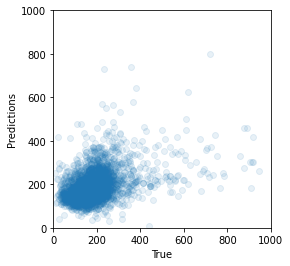

Pearson: (0.4759702004888049, 4.129035685511239e-205)
Spearman: 0.4315046752282406
MAE: 66.56186671357133
MSE: 15163.246959714665
RAE: 93.39221169017073


In [36]:
scatter(true = dev_preds.true, pred = dev_preds.pred)

In [31]:
identifier = f'BOW_{modeltype}_{feature_type}_{str(max_features)}'
print(identifier)

BOW_ridge_abs_1000


In [216]:
dev_preds.to_csv(utils.OUTPUT / "predictions_dev" / f'{identifier}.tsv', sep ="\t", 
                 index=True,
                 index_label="articleId")

BOW_xgboost_abs_1000


In [32]:
dev_preds = pd.read_csv(utils.OUTPUT / "predictions_dev" / f'{identifier}.tsv', sep ="\t", 
                       index_col = "articleId")

In [33]:
dev_preds.sort_values("pred", ascending = False).head(20) # höchste Predictions
#dev_preds.sort_values("pred", ascending = True).head(20) # niedrigste Predictions

,pred,true,article_text,nr,textlength
articleId,,,,,
NOZ_2063514,1238.865752,540.107961,Alicia Kozakiewicz im Interview: Kinderpornogr...,1726.0,4459.0
NOZ_559307,1070.186175,454.701299,„Palmarum Qualmarum“ 1945: Historischer Ticker...,2255.0,3441.0
NOZ_1376771,1037.806057,763.160305,Schauspieler und vierfacher Vater: Wolfram Koc...,2914.0,3400.0
NOZ_570900,801.257985,721.244961,Was kommt nach „Avengers: Endgame“?: Phase 4: ...,22.0,2223.0
NOZ_515048,799.242910,2396.707547,Gitarrist und Sänger im Interview: Farin Urlau...,302.0,2916.0
NOZ_712712,752.157471,1383.452214,Mao Tsetung: „Ich habe meine Mutter getötet“ –...,2820.0,1396.0
NOZ_1997330,740.246026,356.842857,Interview zu Thüringen und AfD: Politikwissens...,3063.0,3260.0
NOZ_2046882,731.314606,231.781250,Schauspieler im Interview: Axel Milberg: Tator...,832.0,3816.0
NOZ_407676,649.770588,1198.602410,„Vaters Traum verwirklicht“ Mit dem Ende der F...,1370.0,3052.0


In [219]:
ind = 2914 #1726 # 3547
shap.force_plot(explainer.expected_value,
                shap_values[ind,:],
                X_dev[ind,:],
                feature_names=feature_names
               )

AssertionError: visualize() can only display Explanation objects (or arrays of them)!